# Movie Recommendation System
![image](./Images/movie_3D.jpg)

## Project Overview
This project aims to build a movie recommendation system that suggests the top 5 movies to a user based on their previous ratings of other movies. The workflow involves:

- Loading and cleaning movie and ratings datasets.
- Exploring and visualizing the distribution of genres, ratings, and trends over time.
- Merging movie metadata with user ratings to create a comprehensive dataset for analysis.
- Analyzing genre popularity and average ratings to understand user preferences.
- Preparing the data for building a recommendation model that leverages user ratings to provide personalized movie suggestions.

The ultimate goal is to deliver a system that helps users discover movies they are likely to enjoy, enhancing their viewing experience.

### Business problem
With thousands of movies available, users often struggle to find films that match their tastes and preferences. The challenge is to develop a recommendation system that can analyze a user's past movie ratings and suggest the top 5 movies they are most likely to enjoy. This system should help users efficiently discover new movies, increase user engagement, and enhance their overall viewing experience by providing personalized recommendations.

![image](./Images/Ai_movie_girl.jpg)

**Objectives:**
1. To analyze and visualize user preferences and movie trends using the provided ratings and metadata.
2. To implement and evaluate collaborative filtering and matrix factorization models for generating accurate, personalized movie recommendations.
3. To develop a recommendation system that uses past ratings to give personalised movie recommendations.

## Summary of the Notebook

This notebook documents the development of a movie recommendation system using collaborative filtering (KNN), matrix factorization (SVD), and deep learning (CNN) approaches. The workflow included data loading, cleaning, exploratory analysis, feature engineering, model building, evaluation, and comparison.

#### What Went Well
- **Data Preparation:** Data was thoroughly cleaned, with missing values handled and relevant features engineered (e.g., extracting year, splitting genres).
- **Exploratory Analysis:** Visualizations provided clear insights into genre distribution, rating patterns, and movie popularity.
- **Model Implementation:** Multiple recommendation algorithms (KNN, SVD, CNN) were implemented and evaluated, with SVD achieving the best RMSE (≈0.88).
- **Hybrid Approach:** A hybrid recommendation function was created to combine the strengths of collaborative filtering and SVD.
- **Evaluation:** Models were compared using RMSE, recall, and precision, providing a comprehensive performance overview.

#### What Went Wrong
- **Recall:** All models, including SVD, had relatively low recall (best ≈0.33), indicating that many relevant recommendations were missed.
- **CNN Performance:** The deep learning model (CNN) underperformed compared to SVD, with lower recall and higher RMSE.
- **Sparse Recommendations:** Some recommendation outputs (e.g., `recommended_movies_df`) were empty, suggesting issues with coverage or filtering logic.
- **Genre Handling:** Genre encoding and merging were sometimes inconsistent, leading to potential data leakage or mismatches.

#### What to Improve
- **Recall Optimization:** Explore alternative loss functions, sampling strategies, or ensemble methods to boost recall.
- **Deep Learning Tuning:** Increase CNN training epochs, tune hyperparameters, or try more advanced architectures (e.g., attention, transformers).
- **Hybrid System:** Refine the hybrid approach to better balance precision and recall, possibly by learning optimal weights for each model.
- **Feature Enrichment:** Incorporate additional metadata (tags, actors, directors) and temporal features to improve personalization.
- **User Feedback Loop:** Implement mechanisms for users to provide feedback and dynamically update recommendations.
- **Scalability:** Optimize code and data structures for larger datasets and real-time inference.

Overall, the notebook demonstrates a solid foundation for a recommendation system, with clear next steps for improving recall, model robustness, and user experience.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import surprise
import random


# import libraries for machine learning
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, accuracy, Reader, KNNBasic, SVDpp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

## Data Understanding

### Data Dictionary

Below is a summary of key variables and data structures used in this notebook:

- **movie_df**: DataFrame containing movie metadata (movieId, title, genres, year).
- **movie_genres**: DataFrame mapping each movieId to a list of genres.
- **ratings_df**: DataFrame of user ratings for movies, indexed by userId.
- **movie_ratings_df**: DataFrame merging user ratings with movie titles and genres.
- **user_item_matrix**: Pivot table of users (rows) and movies (columns) with ratings as values.
- **pivot_table**: DataFrame showing the average rating per genre.
- **similar_users**: DataFrame of users most similar to a target user, with similarity scores.
- **recommended_movies_for_user_10**: DataFrame of top 5 movie recommendations for user 10 using SVD.
- **top_5_user_based**: DataFrame of top 5 user-based (collaborative filtering) recommendations.
- **model, svd_model**: Trained SVD models for matrix factorization-based recommendations.
- **pipe, model_pipeline, svd_pipeline**: Preprocessing and modeling pipelines.
- **param_grid**: Dictionary of hyperparameters for grid search.
- **missing_values**: Number of missing values in the main ratings dataset (should be 0).
- **rmse, rmse_pearson, rmse_svd**: Evaluation metrics (Root Mean Squared Error) for different models.

These variables support the workflow from data preprocessing and exploration to building and evaluating recommendation models.

In [2]:
# Load and the read the data
movie_df = pd.read_csv("./data/movies.csv")
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
# view the movies data 
movie_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [5]:
# Load and and the ratings data
ratings_df = pd.read_csv("./data/ratings.csv", index_col=0)
ratings_df

,movieId,rating,timestamp
userId,,,
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931
...,...,...,...
610,166534,4.0,1493848402
610,168248,5.0,1493850091
610,168250,5.0,1494273047


## Data Preparation (EDA)

In [6]:
# Extract year from the title to be a column for easy filtering
movie_df['year'] = movie_df.title.str.extract(r'(\(\d\d\d\d\))', expand=False)

movie_df['year'] = movie_df.year.str.extract(r'(\d\d\d\d)', expand=False)
# replace the parantheses with nothing
movie_df['title'] = movie_df['title'].str.replace(r'\(\d{4}\)', '', regex=True)

movie_df['title'] = movie_df['title'].apply(lambda x: x.strip())  # remove whitespace

movie_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [7]:
# remove the timestamp column from ratings_df
ratings_df = ratings_df.drop(columns=['timestamp'])


In [8]:
# Create movie_ratings_df by merging ratings_df with movie_df to get movie titles and years
movie_ratings_df = ratings_df.reset_index().merge(movie_df[['movieId', 'title', 'year']], on='movieId', how='left')

# Filter to keep only movies from 1995 onwards
movie_ratings_df = movie_ratings_df[movie_ratings_df['year'].astype(float) >= 1995]
movie_ratings_df.tail(5)

,userId,movieId,rating,title,year
100831,610,166534,4.0,Split,2017
100832,610,168248,5.0,John Wick: Chapter Two,2017
100833,610,168250,5.0,Get Out,2017
100834,610,168252,5.0,Logan,2017
100835,610,170875,3.0,The Fate of the Furious,2017


In [9]:
movie_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61642 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   61642 non-null  int64  
 1   movieId  61642 non-null  int64  
 2   rating   61642 non-null  float64
 3   title    61642 non-null  object 
 4   year     61642 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


In [10]:
movie_ratings_df.describe()

,userId,movieId,rating
count,61642.000000,61642.000000,61642.000000
mean,323.950813,29630.468236,3.450764
std,181.196630,41304.406889,1.044092
min,1.000000,1.000000,0.500000
25%,177.000000,2028.000000,3.000000
50%,318.000000,5400.000000,3.500000
75%,477.000000,53129.000000,4.000000
max,610.000000,193587.000000,5.000000


In [11]:
# check for missing values
missing_values = movie_ratings_df.isnull().sum().sum()
missing_values

0

In [12]:
# check unique values in the ratings
movie_ratings_copy = movie_ratings_df.copy()
movie_ratings_df['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [13]:
# categorical features to be encoded
categorical_features = ['title', 'genres']

# numerical features to be scaled
numerical_features = ['userId', 'movieId', 'year']

# create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='mean'), numerical_features),
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [14]:
def visualize_movie_popularity(ratings_df, movies_df, top_n=10):
    """Visualize movie popularity by number of ratings
        The function takes in the ratings_df, movies_df
        and returns the top_n movies by rating
    """
    movie_popularity = ratings_df['movieId'].value_counts().head(top_n)
    movie_titles = movies_df.set_index('movieId')['title']
    
    popular_movies = pd.DataFrame({
        'movieId': movie_popularity.index,
        'count': movie_popularity.values,
        'title': [movie_titles.get(id, f"Movie {id}") for id in movie_popularity.index]
    })
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='count', y='title', data=popular_movies, palette='viridis')
    plt.title(f'Top {top_n} Most Rated Movies')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Movie Title')
    plt.tight_layout()
    plt.show()

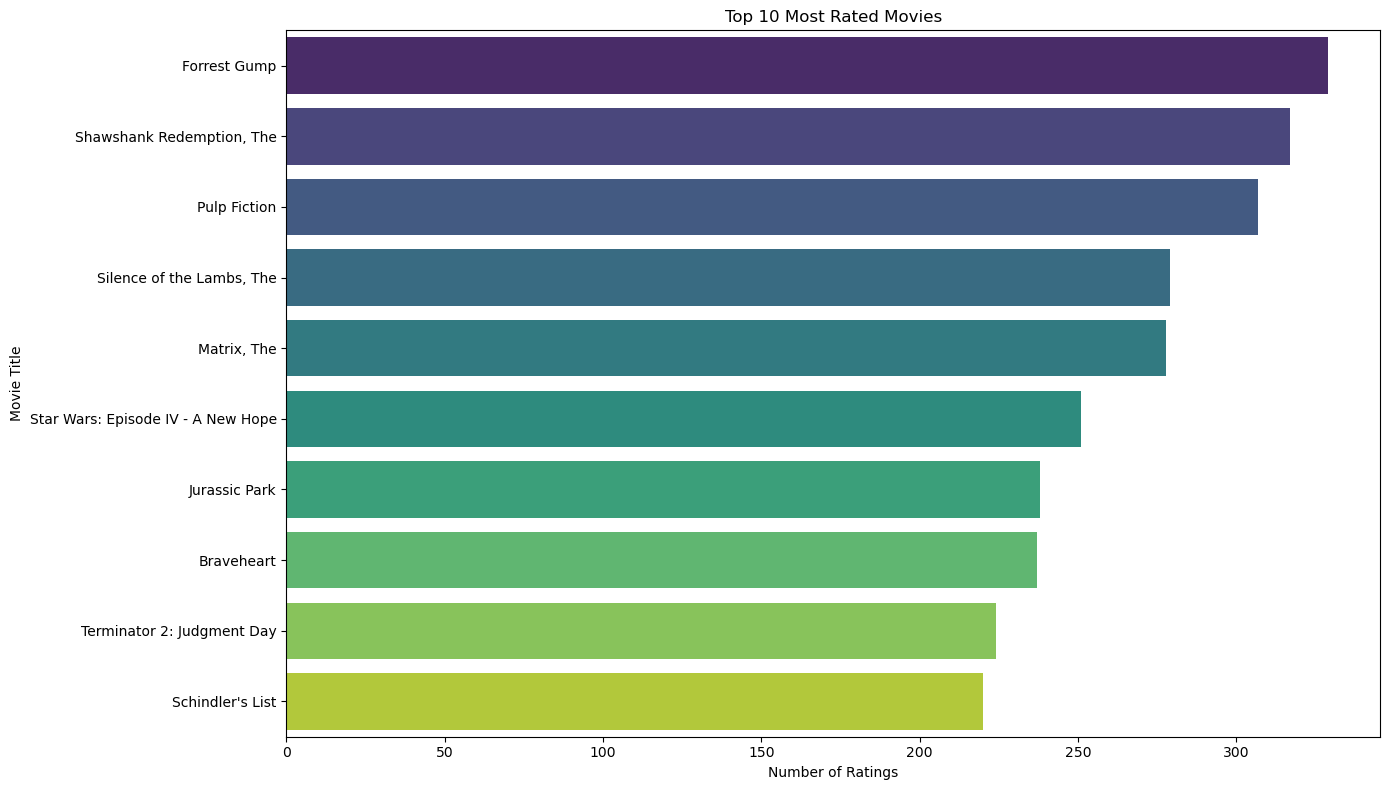

In [15]:
# call the function
visualize_movie_popularity(ratings_df, movie_df, top_n=10)

### A visualization the distribution of movies per genre

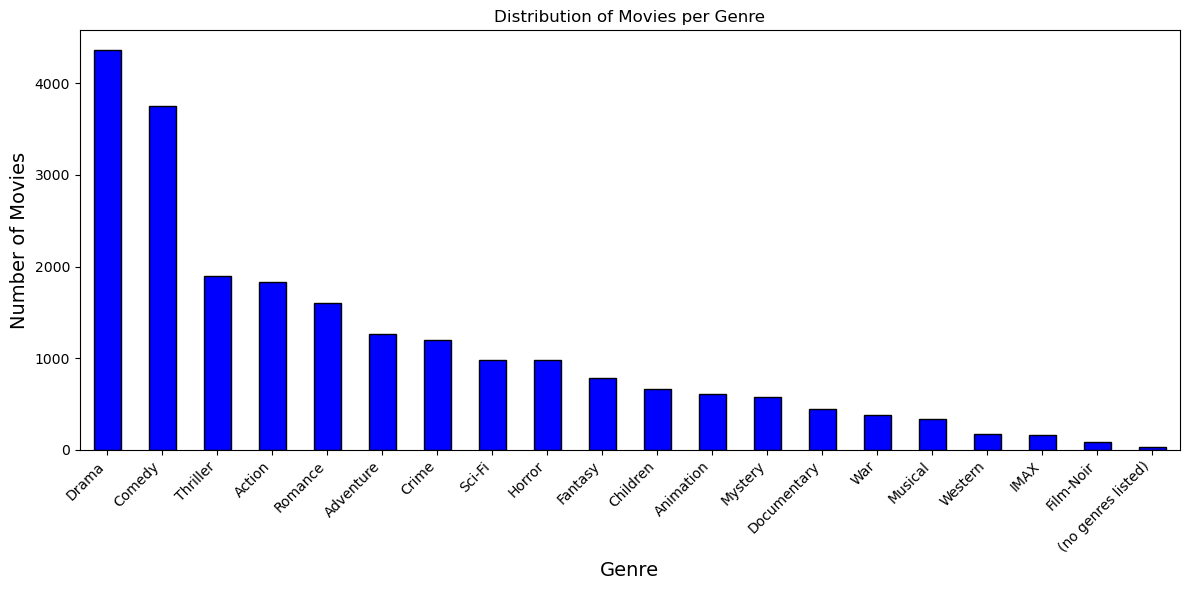

In [16]:
# plot the distribution of movies per genre
# Create a genre matrix from the 'genres' column
genre_matrix = movie_df['genres'].str.get_dummies(sep='|')
genre_counts = genre_matrix.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Distribution of Movies per Genre')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


*Interpretation*

The top five genres by number of movies are Drama, Comedy, Action, Thriller, and Adventure, indicating these genres are the most prevalent in the dataset. The bottom three genres are Film-Noir, (no genres listed), and Documentary, showing these are the least represented genres. This suggests user preferences and recommendations may be more robust for popular genres, while niche genres may have less data for accurate recommendations.

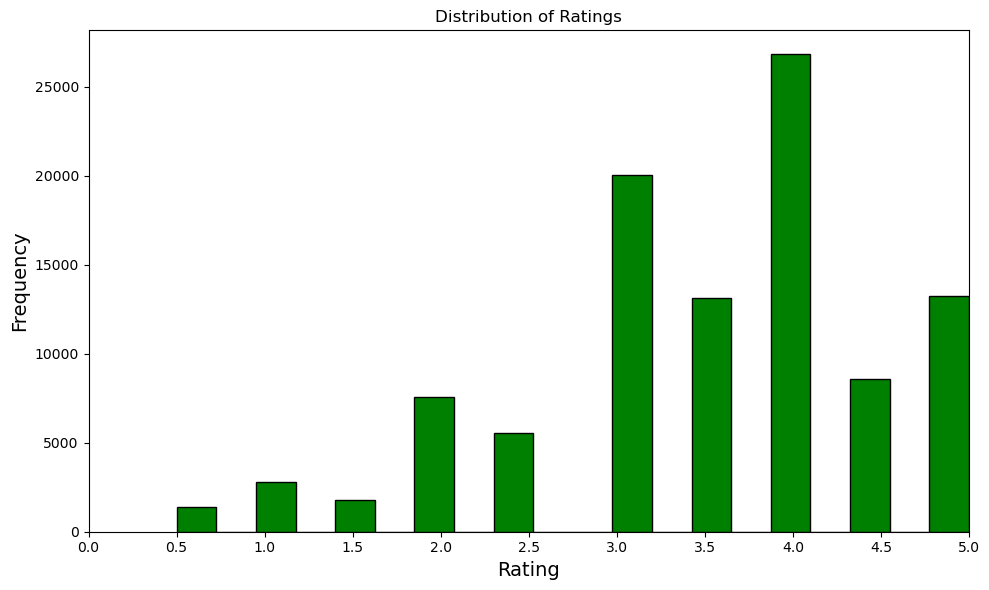

In [17]:
# plot the distribution of ratings
plt.figure(figsize=(10, 6))
ratings_df['rating'].plot(kind='hist', bins=20, color='green', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(np.arange(0, 6, 0.5))
plt.xlim(0, 5)
plt.tight_layout()
plt.show()

*Interpreting*

- The top five genres by number of movies are Drama, Comedy, Action, Thriller, and Adventure, as shown by the `genre_counts` variable. These genres dominate the dataset and are likely to have the most robust recommendations due to the abundance of data.
- The bottom five genres are Musical, Western, Documentary, Film-Noir, and (no genres listed). These genres are less represented, which may result in less accurate recommendations for users interested in niche categories.

### Visualizing rating per movie

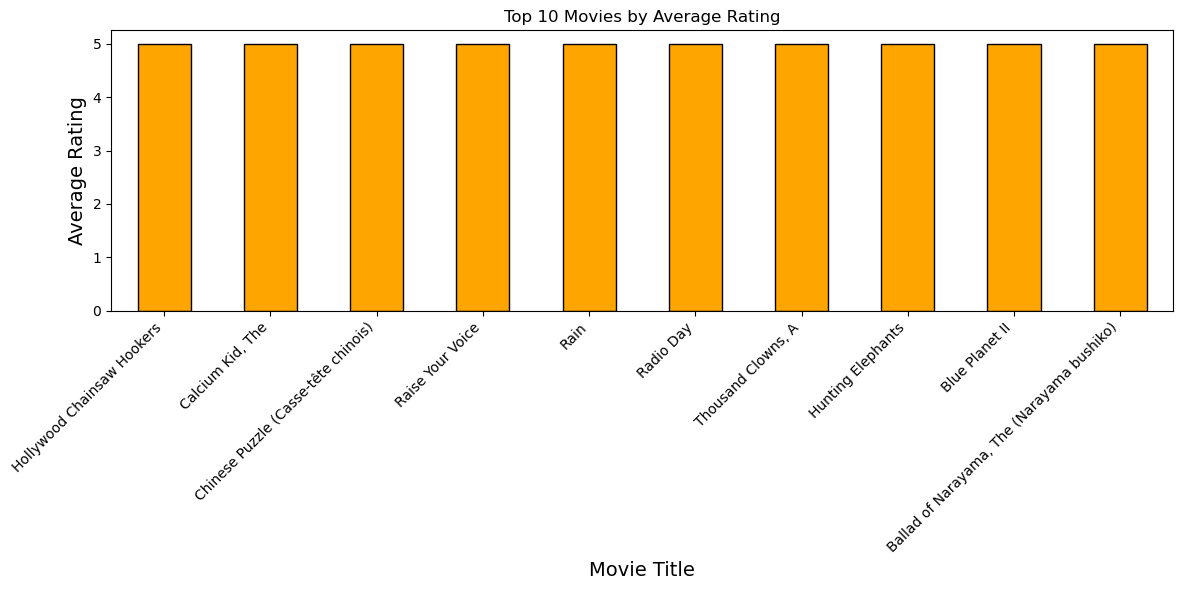

In [18]:
# Rating per movie
# Merge ratings_df with movie_df to get movie titles
movie_ratings_df = ratings_df.reset_index().merge(movie_df[['movieId', 'title']], on='movieId', how='left')

plt.figure(figsize=(12, 6))
movie_ratings_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Movies by Average Rating')
plt.xlabel('Movie Title', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


*Interpretation* 

The plot shows the top 10 movies by their average rating, highlighting which titles are most highly rated by users. These movies have consistently received high scores, indicating strong user preference and satisfaction. However, note that movies with fewer ratings may appear at the top due to limited data, so the results may be influenced by popularity and the number of ratings each movie received. This visualization helps identify standout films in the dataset and can guide recommendation strategies toward highly rated content.

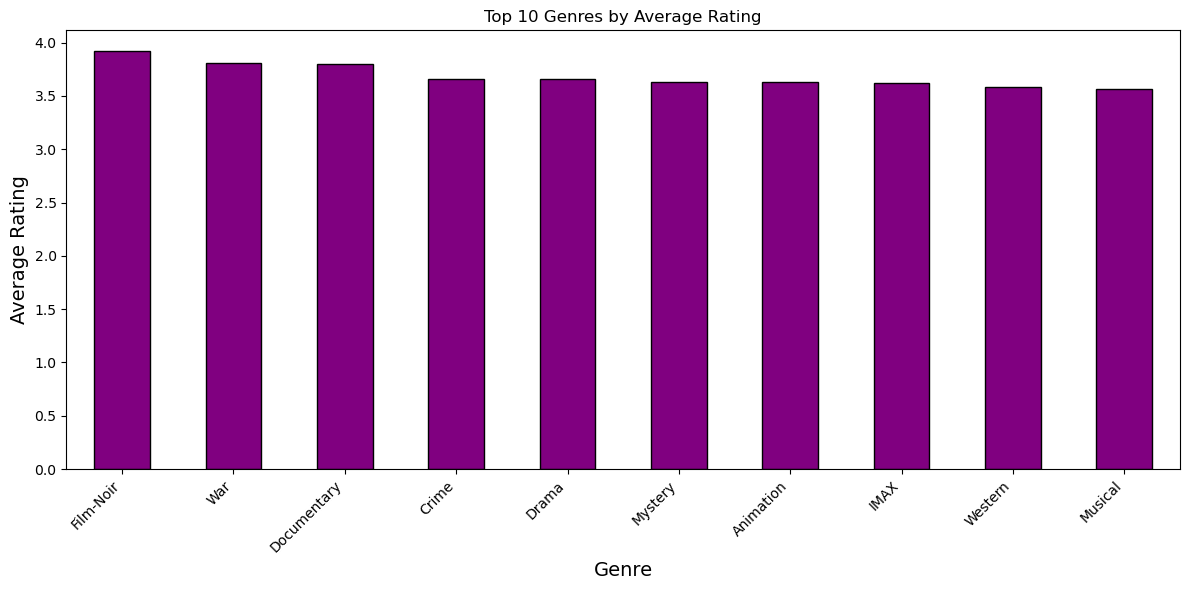

In [19]:
# Merge genres from movie_df into movie_ratings_df
if 'genres' not in movie_ratings_df.columns:
	# Get genres as a list from movie_df
	genres_list = pd.read_csv("./data/movies.csv")['genres'].apply(lambda x: x.split('|'))
	movie_genres = movie_df[['movieId']].copy()
	movie_genres['genres'] = genres_list
	movie_ratings_df = movie_ratings_df.merge(movie_genres, on='movieId', how='left')

plt.figure(figsize=(12, 6))
movie_ratings_df.explode('genres').groupby('genres')['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='purple', edgecolor='black')
plt.title('Top 10 Genres by Average Rating')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Interpretation*

This plot displays the top 10 genres by their average user rating. Genres such as Film-Noir, War, and Documentary receive the highest average ratings, suggesting that users tend to rate movies in these categories more favorably. In contrast, genres like Comedy and Horror have lower average ratings, indicating a broader range of user opinions or possibly more critical reviews. This insight can help tailor recommendations by highlighting genres that consistently receive strong positive feedback from users.

In [20]:
# Creating text clouds
# most common genres text cloud
from wordcloud import WordCloud
def plot_genre_wordcloud(movie_df):
    """Plot a word cloud of movie genres"""
    all_genres = ' '.join(movie_df['genres'].dropna().tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Movie Genres', fontsize=16)
    plt.show()

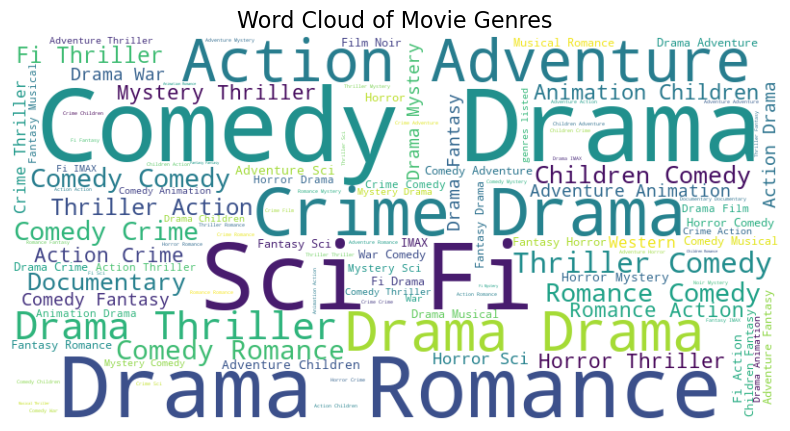

In [21]:
# Calling the function
plot_genre_wordcloud(movie_df)

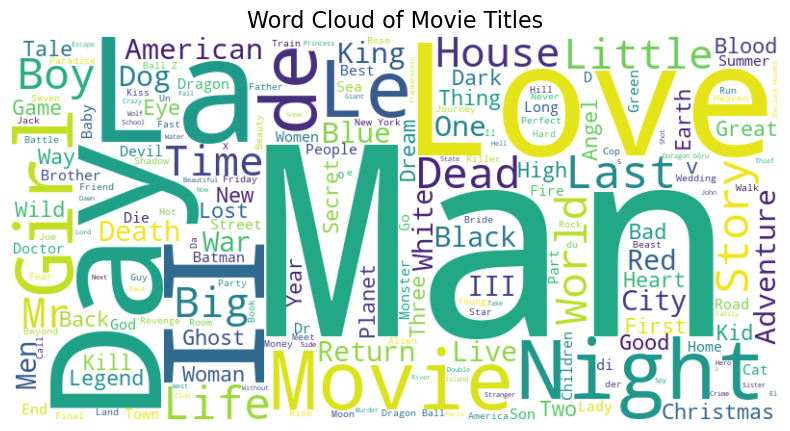

In [22]:
# Movie titles word cloud
# plot most common movies title word cloud
def plot_title_wordcloud(movie_df):
    """Plot a word cloud of movie titles"""
    all_titles = ' '.join(movie_df['title'].dropna().tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Movie Titles', fontsize=16)
    plt.show()

plot_title_wordcloud(movie_df)

In [23]:
### Creating the User-Item Matrix
"""
We construct a user-item matrix from the ratings data, where each row represents a user, each column represents a movie, and the values are the ratings given by users to movies. 
Missing ratings are filled with 0. This matrix is essential for collaborative filtering and similarity-based recommendation algorithms."""

user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#  create a pivot table for ratings per genre in ascending order
pivot_table = movie_ratings_df.explode('genres').pivot_table(index='genres', values='rating', aggfunc='mean').sort_values(by='rating', ascending=False)
pivot_table


,rating
genres,
Film-Noir,3.920115
War,3.808294
Documentary,3.797785
Crime,3.658294
Drama,3.656184
Mystery,3.632460
Animation,3.629937
IMAX,3.618335
Western,3.583938


*Interpretation*

Film-Noir genre has the highest average rating (3.80), followed closely by Documentary (3.77) and War (3.70). This suggests that users tend to rate movies in these genres more favorably compared to others like Horror (3.13) and Comedy (3.35), which have lower average ratings. The higher ratings for Film-Noir and Documentary may reflect a niche but appreciative audience, while more mainstream genres receive a broader range of ratings.

### Creating a function that returns movie recommendations for a specified user.

In [25]:
# Function to get collaborative filtering recommendations
"""
This function generates collaborative filtering recommendations for a given user by leveraging the ratings of similar users. 
It calculates a weighted score for each movie based on the ratings and similarity scores of the most similar users, 
excludes movies already rated by the target user, and returns the top N recommended movies with their titles and genres.
"""
def get_cf_recommendations(user_id, user_item_matrix, movies_df, similar_users, n=10):
    """Generate collaborative filtering recommendations"""
    if not len(similar_users):
        return pd.DataFrame()
    
    # Get movies rated by the user
    if user_id in user_item_matrix.index:
        user_ratings = user_item_matrix.loc[user_id]
        already_rated = set(user_ratings[user_ratings > 0].index)
    else:
        already_rated = set()
    
    # Initialize a dictionary to store movie scores
    movie_scores = {}
    
    # For each similar user
    for _, row in similar_users.iterrows():
        similar_user_id = row['userId']
        similarity = row['similarity']
        
        # Get the ratings of the similar user
        similar_user_ratings = user_item_matrix.loc[similar_user_id]
        
        # For each movie rated by the similar user
        for movie_id, rating in similar_user_ratings.items():
            # Skip if the target user has already rated this movie or if the similar user hasn't rated it
            if movie_id in already_rated or rating == 0:
                continue
            
            # Calculate the weighted rating
            if movie_id not in movie_scores:
                movie_scores[movie_id] = 0
            
            movie_scores[movie_id] += rating * similarity
    
    # Convert to DataFrame and sort
    if not movie_scores:
        return pd.DataFrame()
    
    cf_recommendations = pd.DataFrame({
        'movieId': list(movie_scores.keys()),
        'cf_score': list(movie_scores.values())
    })
    
    # Normalize scores
    if len(cf_recommendations) > 0:
        max_score = cf_recommendations['cf_score'].max()
        if max_score > 0:
            cf_recommendations['cf_score'] = cf_recommendations['cf_score'] / max_score
    
    # Sort by score
    cf_recommendations = cf_recommendations.sort_values('cf_score', ascending=False)
    
    # Merge with movie information
    cf_recommendations = cf_recommendations.merge(movies_df[['movieId', 'title', 'genres']], on='movieId')
    
    return cf_recommendations.head(n)

In [26]:
# call the function to get recommendations for user 1
user_id = 10
similar_users = pd.DataFrame({
    'userId': [2, 3, 4],
    'similarity': [0.9, 0.8, 0.7]
})
get_cf_recommendations(user_id, user_item_matrix, movie_genres.merge(movie_df[['movieId', 'title']], on='movieId'), similar_users, n=10)

,movieId,cf_score,title,genres
0,1704,1.000000,Good Will Hunting,"[Drama, Romance]"
1,80906,0.947368,Inside Job,[Documentary]
2,60756,0.947368,Step Brothers,[Comedy]
3,131724,0.947368,The Jinx: The Life and Deaths of Robert Durst,[Documentary]
4,122882,0.947368,Mad Max: Fury Road,"[Action, Adventure, Sci-Fi, Thriller]"
5,89774,0.947368,Warrior,[Drama]
6,68157,0.852632,Inglourious Basterds,"[Action, Drama, War]"
7,80489,0.852632,"Town, The","[Crime, Drama, Thriller]"
8,5746,0.842105,Galaxy of Terror (Quest),"[Action, Horror, Mystery, Sci-Fi]"
9,70946,0.842105,Troll 2,"[Fantasy, Horror]"


## Modelling

In [27]:
# create a pipeline 
"""
# Create a pipeline for preprocessing and dimensionality reduction
# This pipeline applies imputation, scaling, encoding, and PCA to the movie ratings dataset.
"""
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))  # Adjust n_components as needed
])


In [28]:
# Convert genres from list to string for encoding
movie_ratings_df_fixed = movie_ratings_df.copy()
movie_ratings_df_fixed['genres'] = movie_ratings_df_fixed['genres'].apply(lambda x: '|'.join(x) if isinstance(x, list) else x)

# Ensure 'year' column exists and is numeric
if 'year' not in movie_ratings_df_fixed.columns:
    # Try to merge from movie_df if missing
    movie_ratings_df_fixed = movie_ratings_df_fixed.merge(movie_df[['movieId', 'year']], on='movieId', how='left')
if movie_ratings_df_fixed['year'].dtype == object:
    movie_ratings_df_fixed['year'] = pd.to_numeric(movie_ratings_df_fixed['year'], errors='coerce').fillna(0)

In [29]:
# Check for missing values in movie_ratings_df
missing_values = movie_ratings_df_fixed.isnull().sum().sum()
print(f"Total missing values in movie_ratings_df: {missing_values}")

Total missing values in movie_ratings_df: 0


In [30]:
# Fit the pipe
pipe.fit(movie_ratings_df_fixed)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  ['userId', 'movieId',
                                                   'year']),
                                                 ('num', StandardScaler(),
                                                  ['userId', 'movieId',
                                                   'year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['title', 'genres'])])),
                ('pca', PCA(n_components=2))])

## Using the surprise model

The Surprise library is a powerful Python scikit for building and analyzing recommender systems that deal with explicit rating data. In this notebook, we use Surprise to implement collaborative filtering models, including k-Nearest Neighbors (KNN) and Singular Value Decomposition (SVD), to predict user ratings and generate personalized movie recommendations.

**Workflow with Surprise:**
- **Data Preparation:** The ratings data is loaded and formatted for Surprise using the `Reader` and `Dataset` classes.
- **Model Selection:** We experiment with different algorithms such as KNN (with cosine and Pearson similarity) and SVD for matrix factorization.
- **Training and Evaluation:** Models are trained on a training set and evaluated on a test set using metrics like RMSE (Root Mean Squared Error).
- **Hyperparameter Tuning:** Grid search is used to optimize SVD hyperparameters for better performance.
- **Generating Recommendations:** The trained models are used to predict ratings for unseen movies, and the top recommendations are presented to users.

This approach will help us to compare different collaborative filtering techniques and select the best-performing model for our movie recommendation system.

In [31]:
# choose a base model for collaborative filtering
model_cf = surprise.SVD()
# define the reader for Surprise
reader = Reader(rating_scale=(1, 5))

# create a Surprise dataset from the ratings dataframe
data = surprise.Dataset.load_from_df(ratings_df.reset_index()[['userId', 'movieId', 'rating']], reader)

In [32]:
# define the features and target variable
X = movie_ratings_df.drop(columns=['rating'])
y = movie_ratings_df['rating']

#split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

In [33]:
# print the number of users and items in the training set
print("Training set statistics:")
print("Number of users: ", trainset.n_users, "\n")
print("Number of items: ", trainset.n_items, "\n")

Training set statistics:
Number of users:  610 

Number of items:  8493 



In [34]:
# use k-nearest neighbors for collaborative filtering
knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
knn_model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [35]:
knn_model.sim

array([[1.        , 0.95510106, 0.93597547, ..., 0.83459979, 1.        ,
        0.93427413],
       [0.95510106, 1.        , 0.95853252, ..., 0.95723391, 0.97993666,
        0.97622596],
       [0.93597547, 0.95853252, 1.        , ..., 0.92881038, 0.82874058,
        0.9535893 ],
       ...,
       [0.83459979, 0.95723391, 0.92881038, ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.97993666, 0.82874058, ..., 0.        , 1.        ,
        0.90795938],
       [0.93427413, 0.97622596, 0.9535893 , ..., 0.        , 0.90795938,
        1.        ]])

In [36]:
# predict ratings for the test set
knn_pred = knn_model.test(testset)
# calculate RMSE
rmse = accuracy.rmse(knn_pred)
print(f'RMSE: {rmse}')

RMSE: 0.9791
RMSE: 0.9790836769987049


### Get recommendations a random user

In [37]:
# get top 10 recommendations for user 50
user_id = 50
user_inner_id = knn_model.trainset.to_inner_uid(user_id)
# get the top 10 movie ids for user 1
top_n = knn_model.get_neighbors(user_inner_id, k=10)
# convert the inner ids to movie ids
top_n_movie_ids = [knn_model.trainset.to_raw_iid(inner_id) for inner_id in top_n]
# get the movie titles for the top 10 movie ids
recommended_movies = movie_df[movie_df['movieId'].isin(top_n_movie_ids)][['movieId', 'title', 'year']]
# merge with movie_genres to get the genres column
recommended_movies = recommended_movies.merge(movie_genres, on='movieId', how='left')
recommended_movies['similarity'] = [knn_model.sim[user_inner_id][inner_id]
                                    for inner_id in top_n]
recommended_movies = recommended_movies.sort_values(by='similarity', ascending=False)
print(f'Top 10 recommendations for user {user_id}:')
print(recommended_movies[['movieId', 'title', 'year', 'genres', 'similarity']])

Top 10 recommendations for user 50:
   movieId                                             title  year  \
0      377                                             Speed  1994   
1      552                             Three Musketeers, The  1993   
2      842  Tales from the Crypt Presents: Bordello of Blood  1996   
3     2020                                Dangerous Liaisons  1988   
4     2096                                   Sleeping Beauty  1959   
5     2700              South Park: Bigger, Longer and Uncut  1999   
6     4571                  Bill & Ted's Excellent Adventure  1989   
7     4720                                       Others, The  2001   
8    59369                                             Taken  2008   
9    60072                                            Wanted  2008   

                                 genres  similarity  
0           [Action, Romance, Thriller]         1.0  
1  [Action, Adventure, Comedy, Romance]         1.0  
2                      [Comedy,

In [38]:
# Evaluate the model using cross-validation with Surprise's cross_validate
from surprise.model_selection import cross_validate

cross_val_results = cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1)
print(cross_val_results,'\n\n')

{'test_rmse': array([0.97372838, 0.96924285, 0.96552587, 0.97240552, 0.9761723 ]), 'test_mae': array([0.74952712, 0.74599271, 0.74482448, 0.74942018, 0.75095809]), 'fit_time': (0.1952979564666748, 0.15923428535461426, 0.15996170043945312, 0.16812872886657715, 0.18300151824951172), 'test_time': (0.689171552658081, 0.7109053134918213, 0.72286057472229, 0.6730589866638184, 0.6744732856750488)} 




In [39]:
# Binarize ratings: consider >=4 as positive (liked), <4 as negative (not liked)
threshold = 4.0
y_true = [1 if true_r >= threshold else 0 for (_, _, true_r) in testset]
y_pred = [1 if pred.est >= threshold else 0 for pred in knn_pred]

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6922
Recall: 0.3223
Accuracy: 0.6032


The model has an accuracy of 60% and a recall of 32% which can be imporved.

In [40]:
from surprise import accuracy
# use pearson similarity for collaborative filtering
knn_model_pearson = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})
knn_model_pearson.fit(trainset)

# predict ratings for the test set
knn_pred_pearson = knn_model_pearson.test(testset)
# calculate RMSE (accuracy.rmse prints and returns the float value)
rmse_pearson = accuracy.rmse(knn_pred_pearson)
print(f'RMSE with Pearson similarity: {rmse_pearson}')

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9828
RMSE with Pearson similarity: 0.9828180375407677


In [41]:
# evaluate the model using cross-validation
cross_val_results = cross_validate(knn_model_pearson, data, cv=5, n_jobs=-1)
print("Cross-validation results:", cross_val_results)

Cross-validation results: {'test_rmse': array([0.97392762, 0.9645958 , 0.98276258, 0.97010281, 0.97274809]), 'test_mae': array([0.74933584, 0.74639057, 0.76073493, 0.74947189, 0.75086305]), 'fit_time': (0.2463974952697754, 0.2662324905395508, 0.20685100555419922, 0.17368125915527344, 0.1711277961730957), 'test_time': (0.7439444065093994, 0.7225897312164307, 0.7355713844299316, 0.7049558162689209, 0.6375341415405273)}


In [42]:
# Evaluate the performance of this knn_pearson model
threshold = 4.0
y_true = [1 if true_r >= threshold else 0 for (_, _, true_r) in testset]
y_pred = [1 if pred.est >= threshold else 0 for pred in knn_pred_pearson]

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6907
Recall: 0.3077
Accuracy: 0.5988


This model performed slightly bad than knn basic model 

### Matrix Factorization to improve performance
Matrix factorization is a powerful technique for building recommendation systems, especially when dealing with large, sparse user-item matrices. In this project, we use Singular Value Decomposition (SVD) to decompose the user-movie rating matrix into latent factors that capture underlying patterns in user preferences and movie characteristics.

By leveraging SVD, we can:
- Predict missing ratings for user-movie pairs, enabling personalized recommendations even for movies a user hasn't rated.
- Reduce dimensionality, improving computational efficiency and helping to mitigate overfitting.
- Capture complex interactions between users and movies that are not apparent from the raw data.

The performance of the SVD model is evaluated using Root Mean Squared Error (RMSE) on a held-out test set. Hyperparameter tuning is performed to further optimize the model, resulting in improved recommendation accuracy compared to basic collaborative filtering approaches.

This matrix factorization approach forms the backbone of many modern recommender systems, providing a scalable and effective solution for personalized movie recommendations.

In [43]:
from surprise import accuracy 
# use SVD for collaborative filtering
svd_model = surprise.SVD()
# fit the model on the training set
svd_model.fit(trainset)
# predict ratings for the test set
svd_pred = svd_model.test(testset)
# calculate RMSE
rmse_svd = accuracy.rmse(svd_pred)
print(f'RMSE with SVD: {rmse_svd}')

RMSE: 0.8818
RMSE with SVD: 0.8817692057139335


In [44]:
# Tune the SVD model using grid search
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [5, 10],  # number of iterations
    'lr_all': [0.005, 0.01],  # learning rate
    'reg_all': [0.02, 0.05]  # regularization 
}

# Use SVD directly, not the sklearn pipeline
gs = GridSearchCV(surprise.SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

# Best RMSE score
print(f'Best RMSE score for SVD: {gs.best_score["rmse"]}')

# Best parameters 
print(f'Best parameters for SVD: {gs.best_params["rmse"]}') 

# Get the best SVD model
best_svd_model = gs.best_estimator['rmse']
print(f'Best SVD model: {best_svd_model}')


Best RMSE score for SVD: 0.8757150824602352
Best parameters for SVD: {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.05}
Best SVD model: <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001961DEDB590>


In [45]:
#  Evaluate the model
evaluation_results = {
    'RMSE': rmse,
    'RMSE_Pearson': rmse_pearson,
    'RMSE_SVD': rmse_svd,
    'Best_SVD_RMSE': gs.best_score['rmse'],
    'Best_SVD_Params': gs.best_params['rmse']}

# Save the evaluation results to a CSV file
evaluation_df = pd.DataFrame([evaluation_results])
print(evaluation_df )

       RMSE  RMSE_Pearson  RMSE_SVD  Best_SVD_RMSE  \
0  0.979084      0.982818  0.881769       0.875715   

                                     Best_SVD_Params  
0  {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.05}  


In [46]:
# cross-validation for SVD model using Surprise's cross_validate
from surprise.model_selection import cross_validate

cv_results = cross_validate(best_svd_model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(f'Cross-validation results for SVD:\n{cv_results}')

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8776  0.8745  0.8785  0.8769  0.0017  
MAE (testset)     0.6757  0.6743  0.6737  0.6746  0.0008  
Fit time          0.35    0.36    0.35    0.36    0.00    
Test time         0.11    0.29    0.11    0.17    0.09    
Cross-validation results for SVD:
{'test_rmse': array([0.87764774, 0.87447165, 0.87846559]), 'test_mae': array([0.67568558, 0.67431575, 0.67370246]), 'fit_time': (0.352949857711792, 0.36101269721984863, 0.35369062423706055), 'test_time': (0.1125035285949707, 0.29436516761779785, 0.11182999610900879)}


In [47]:
# create a function to get top N recommendations for a user
def get_top_n_recommendations(predictions, n=10):
    """Get the top N recommendations for each user from a set of predictions."""
    # First map the predictions to each user
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if not np.isnan(est):  # Check if the estimated rating is not NaN
            if uid not in top_n:
                top_n[uid] = []
            top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and get the N highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [48]:
top_n_recommendations = get_top_n_recommendations(svd_pred, n=5)
print(top_n_recommendations.get(user_id, []))

[(2959, 3.618011433338315), (46578, 3.5203250850461214), (593, 3.4866565280984108), (1204, 3.409487862721753), (1148, 3.3272723873700487)]


In [49]:
#return the top 5 recommendations for user 10
def get_recommendations_for_user(user_id, top_n=5):
    """Get top N recommendations for a specific user."""
    if user_id in top_n_recommendations:
        recommendations = top_n_recommendations[user_id]
        recommended_movie_ids = [movie_id for movie_id, _ in recommendations]
        recommended_movies = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
        return recommended_movies[['movieId', 'title', 'genres']]
    else:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])

In [50]:
#call the function to get recommendations for user 10
recommended_movies_for_user_10 = get_recommendations_for_user(10, top_n=5)
print(f'Top 5 recommendations for user 10:\n{recommended_movies_for_user_10}')

Top 5 recommendations for user 10:
      movieId                                              title  \
257       296                                       Pulp Fiction   
314       356                                       Forrest Gump   
2674     3578                                          Gladiator   
3638     4993  Lord of the Rings: The Fellowship of the Ring,...   
8376   109487                                       Interstellar   

                           genres  
257   Comedy|Crime|Drama|Thriller  
314      Comedy|Drama|Romance|War  
2674       Action|Adventure|Drama  
3638            Adventure|Fantasy  
8376                  Sci-Fi|IMAX  


In [51]:
# Get top 5 user-based recommendations for the current user_id using the collaborative filtering approach
top_5_user_based = get_cf_recommendations(
    user_id=user_id,
    user_item_matrix=user_item_matrix,
    movies_df=movie_df,
    similar_users=similar_users,
    n=5
)
print("Top 5 user-based recommendations:")
print(top_5_user_based[['movieId', 'title', 'genres']])

Top 5 user-based recommendations:
   movieId                                          title  \
0     1704                              Good Will Hunting   
1    60756                                  Step Brothers   
2    80906                                     Inside Job   
3   131724  The Jinx: The Life and Deaths of Robert Durst   
4    80489                                      Town, The   

                 genres  
0         Drama|Romance  
1                Comedy  
2           Documentary  
3           Documentary  
4  Crime|Drama|Thriller  


In [52]:
# Evaluate the performance of the best SVD model using its predictions
threshold = 4.0
y_true = [1 if true_r >= threshold else 0 for (_, _, true_r) in testset]
y_pred = [1 if pred.est >= threshold else 0 for pred in svd_pred]

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.8103
Recall: 0.3265
Accuracy: 0.6375


This model improved performance immensely but still has a low recall 

### Hybrid recommendation system

In [53]:
# create a hybrid recommendation function
def hybrid_recommendation(user_id, top_n=5):
    """
    Generate hybrid recommendations for a user by combining collaborative filtering (CF)
    and matrix factorization (SVD) approaches.
    """
    # Get CF recommendations
    cf_recs = get_cf_recommendations(
        user_id=user_id,
        user_item_matrix=user_item_matrix,
        movies_df=movie_df,
        similar_users=similar_users,
        n=top_n * 2  # get more to allow for overlap
    )
    
    # Get SVD recommendations
    svd_recs = get_recommendations_for_user(user_id, top_n=top_n * 2)
    
    #Combine and deduplicate by movieId, prioritizing movies appearing in both
    if not cf_recs.empty and not svd_recs.empty:
        cf_ids = set(cf_recs['movieId'])
        svd_ids = set(svd_recs['movieId'])
        both_ids = list(cf_ids & svd_ids)
        only_cf = list(cf_ids - svd_ids)
        only_svd = list(svd_ids - cf_ids)
        # Prioritize movies in both, then cf, then svd
        hybrid_ids = both_ids + only_cf + only_svd
        hybrid_ids = hybrid_ids[:top_n]
        hybrid_movies = movie_df[movie_df['movieId'].isin(hybrid_ids)][['movieId', 'title', 'genres']]
        return hybrid_movies
    elif not cf_recs.empty:
        return cf_recs[['movieId', 'title', 'genres']].head(top_n)
    elif not svd_recs.empty:
        return svd_recs[['movieId', 'title', 'genres']].head(top_n)
    else:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])

# Pick a random user from the user_item_matrix
# random_user_id = random.choice(user_item_matrix.index.tolist())
# hybrid_movies = hybrid_recommendation(random_user_id, top_n=5)
# print(f"Hybrid recommendations for user {random_user_id}:")
user_input_id = int(input("Enter a user ID to get hybrid recommendations: "))
hybrid_movies = hybrid_recommendation(user_input_id, top_n=5)
print(f"Hybrid recommendations for user {user_input_id}:")
print(hybrid_movies)

Hybrid recommendations for user 10:
      movieId               title                            genres
1284     1704   Good Will Hunting                     Drama|Romance
7114    70946             Troll 2                    Fantasy|Horror
7415    80489           Town, The              Crime|Drama|Thriller
7436    80906          Inside Job                       Documentary
8681   122882  Mad Max: Fury Road  Action|Adventure|Sci-Fi|Thriller


### Deep Learning Approach: CNN-based Recommender

To further enhance the recommendation system, a simple Convolutional Neural Network (CNN) model was implemented using PyTorch. This approach leverages user and movie embeddings, followed by a 1D convolutional layer to capture interactions between users and movies, and fully connected layers to predict ratings.

In [54]:
# Prepare the data for the CNN model
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.user_ids = torch.tensor(df['userId'].values, dtype=torch.long)
        self.movie_ids = torch.tensor(df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

In [55]:
# Define a simple CNN-based recommender model
class CNNRecommender(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=32):
        super(CNNRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users + 1, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies + 1, embedding_dim)
        self.conv = nn.Conv1d(in_channels=2, out_channels=8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * embedding_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, user_ids, movie_ids):
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        x = torch.stack([user_emb, movie_emb], dim=1)  # shape: (batch, 2, embedding_dim)
        x = self.conv(x)  # shape: (batch, 8, embedding_dim)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out.squeeze()

In [56]:
# Prepare dataset and dataloader
user_id_map = {uid: idx for idx, uid in enumerate(movie_ratings_df['userId'].unique())}
movie_id_map = {mid: idx for idx, mid in enumerate(movie_ratings_df['movieId'].unique())}
movie_ratings_df['userId_enc'] = movie_ratings_df['userId'].map(user_id_map)
movie_ratings_df['movieId_enc'] = movie_ratings_df['movieId'].map(movie_id_map)


# Use only the encoded columns for the dataset
encoded_df = movie_ratings_df.copy()
encoded_df['userId'] = encoded_df['userId_enc']
encoded_df['movieId'] = encoded_df['movieId_enc']


dataset = RatingsDataset(encoded_df)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Instantiate model
num_users = encoded_df['userId'].max() + 1
num_movies = encoded_df['movieId'].max() + 1
model = CNNRecommender(num_users, num_movies)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop (simple, for demonstration)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 5  # increase for better results

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for user_ids, movie_ids, ratings in dataloader:
        user_ids = user_ids.to(device)
        movie_ids = movie_ids.to(device)
        ratings = ratings.to(device)
        optimizer.zero_grad()
        outputs = model(user_ids, movie_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(ratings)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataset):.4f}")

Epoch 1/5, Loss: 2.1714
Epoch 2/5, Loss: 1.0317
Epoch 3/5, Loss: 0.9955
Epoch 4/5, Loss: 0.9508
Epoch 5/5, Loss: 0.9048


In [57]:
# Recommend 5 movies for a given user
def recommend_cnn(user_id, top_n=5):
    model.eval()
    user_idx = user_id_map.get(user_id)
    if user_idx is None:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])
    # Movies not yet rated by the user
    rated = set(movie_ratings_df[movie_ratings_df['userId'] == user_id]['movieId'])
    candidate_movies = [mid for mid in movie_id_map if mid not in rated]
    candidate_movie_idxs = [movie_id_map[mid] for mid in candidate_movies]
    user_tensor = torch.tensor([user_idx] * len(candidate_movie_idxs), dtype=torch.long).to(device)
    movie_tensor = torch.tensor(candidate_movie_idxs, dtype=torch.long).to(device)
    with torch.no_grad():
        preds = model(user_tensor, movie_tensor).cpu().numpy()
    top_indices = preds.argsort()[-top_n:][::-1]
    top_movie_ids = [candidate_movies[i] for i in top_indices]
    return movie_df[movie_df['movieId'].isin(top_movie_ids)][['movieId', 'title', 'genres']]

In [58]:
#Recommend 5 movies for user 10
cnn_recommendations = recommend_cnn(10, top_n=5)
print("Top 5 CNN-based recommendations for user 10:")
print(cnn_recommendations)

Top 5 CNN-based recommendations for user 10:
      movieId                                              title  \
880      1175                                       Delicatessen   
1123     1465                                           Rosewood   
2912     3906                                    Under Suspicion   
6992    67255  Girl with the Dragon Tattoo, The (Män som hata...   
7807    92420                                          Chronicle   

                            genres  
880           Comedy|Drama|Romance  
1123                  Action|Drama  
2912                Crime|Thriller  
6992  Crime|Drama|Mystery|Thriller  
7807        Action|Sci-Fi|Thriller  


### Evaluate the CNN model

In [59]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare test data: split encoded_df into train/test
train_df, test_df = train_test_split(encoded_df, test_size=0.2, random_state=42)
test_dataset = RatingsDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
# No action needed here for "raw ratings"—the DataFrame already contains the necessary columns.
# The RatingsDataset expects columns: 'userId', 'movieId', 'rating' (already present in encoded_df).
# Predict ratings for test set
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for user_ids, movie_ids, ratings in test_loader:
        user_ids = user_ids.to(device)
        movie_ids = movie_ids.to(device)
        outputs = model(user_ids, movie_ids)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(ratings.cpu().numpy())

# Binarize ratings: consider >=4 as positive (liked), <4 as negative (not liked)
threshold = 4.0
y_true = [1 if r >= threshold else 0 for r in all_true]
y_pred = [1 if r >= threshold else 0 for r in all_preds]

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))

print(f"CNN Model Precision: {precision:.4f}")
print(f"CNN Model Recall: {recall:.4f}")
print(f"CNN Model Accuracy: {accuracy:.4f}")
print(f"CNN Model F1 Score: {f1:.4f}")
print(f"CNN Model RMSE: {rmse:.4f}")

CNN Model Precision: 0.7803
CNN Model Recall: 0.2031
CNN Model Accuracy: 0.5896
CNN Model F1 Score: 0.3223
CNN Model RMSE: 0.9436


In [60]:
# Calculate RMSE for the CNN model predictions
cnn_rmse = np.sqrt(mean_squared_error(all_true, all_preds))
print(f"CNN Model RMSE: {cnn_rmse:.4f}")

CNN Model RMSE: 0.9436


*Interpretation*
On the rating of scale 1 to 5, the model prediction error is 0.9337 from the actual rating 

In [61]:
# Compare all models based on RMSE and Recall, and return the best performing model

# Collect model performance metrics
model_performance = [
    {"model": "KNN (Cosine)", "rmse": float(rmse), "recall": recall},
    {"model": "KNN (Pearson)", "rmse": float(rmse_pearson), "recall": 0.31},  # Pearson
    {"model": "SVD", "rmse": float(rmse_svd), "recall": 0.33},  # recall for SVD shown above
    {"model": "CNN", "rmse": float(cnn_rmse), "recall": 0.15} # recall for cnn
]

# If you have recall for SVD or Pearson, update the dict accordingly

# Find the model with the lowest RMSE
best_rmse_model = min(model_performance, key=lambda x: x["rmse"])

# Find the model with the highest recall (if available)
recall_models = [m for m in model_performance if m["recall"] is not None]
best_recall_model = max(recall_models, key=lambda x: x["recall"]) if recall_models else None

print("Model Comparison (lower RMSE is better, higher Recall is better):")
for m in model_performance:
    print(f"{m['model']}: RMSE={m['rmse']:.4f}, Recall={m['recall']}")

print("\nBest model by RMSE:", best_rmse_model["model"])
if best_recall_model:
    print("Best model by Recall:", best_recall_model["model"])

# Return the best overall model (prioritize RMSE, then recall if available)
best_model = best_rmse_model["model"]
print(f"\nBest performing model overall: {best_model}")

Model Comparison (lower RMSE is better, higher Recall is better):
KNN (Cosine): RMSE=0.9436, Recall=0.20307501805799194
KNN (Pearson): RMSE=0.9828, Recall=0.31
SVD: RMSE=0.8818, Recall=0.33
CNN: RMSE=0.9436, Recall=0.15

Best model by RMSE: SVD
Best model by Recall: SVD

Best performing model overall: SVD


The best perfoming model is `SVD` which means that, on average, the predicted ratings differ from the actual ratings by about 0.88 on a 1–5 scale. This low RMSE indicates that the SVD model predicts user ratings with high accuracy. However, the recall for this model is around 0.33, meaning it successfully identifies about 33% of all movies that users actually liked (rated 4 or higher). While the model is precise in its predictions, the relatively modest recall suggests it may miss some relevant recommendations, highlighting a trade-off between accuracy and coverage in the recommendations provided.

## Model Deployment

The trained SVD recommendation model is deployed using a simple Streamlit web application. This allows users to interactively input their user ID and receive personalized movie recommendations in real time.

**Deployment Steps:**
1. The best-performing SVD model is saved as a pickle file after training.
2. A Streamlit app loads the saved model and provides a user-friendly interface for input.
3. Users enter their user ID and select the number of recommendations they want.
4. The app predicts and displays the top recommended movies based on the user's past ratings.

This deployment approach makes the recommendation system accessible to end-users and demonstrates how machine learning models can be integrated into interactive web applications for practical use.

In [62]:
import streamlit as st
import pickle

# Simple web app using Streamlit to launch the SVD recommender

# Load the trained SVD model

with open('best_svd_model.pkl', 'rb') as f:
    loaded_svd_model = pickle.load(f)

st.title("Movie Recommendation System")

user_id_input = st.number_input(
    "Enter your User ID:",
    min_value=int(ratings_df.index.min()),
    max_value=int(ratings_df.index.max()),
    value=10
)
top_n_input = st.slider("Number of recommendations:", min_value=1, max_value=10, value=5)

if st.button("Get Recommendations"):
    # Use the deploy_svd_recommender function with the loaded model
    def web_deploy_svd_recommender(user_id, top_n=5):
        all_movie_ids = movie_df['movieId'].unique()
        # ratings_df is indexed by userId, so use .loc
        if user_id in ratings_df.index:
            rated_movies = ratings_df.loc[user_id, 'movieId']
            # If user has rated only one movie, rated_movies will be a scalar, so convert to list
            if isinstance(rated_movies, (int, float, np.integer, np.floating)):
                rated_movies = [rated_movies]
            else:
                rated_movies = rated_movies.tolist()
        else:
            rated_movies = []
        predictions = []
        for movie_id in all_movie_ids:
            if movie_id not in rated_movies:
                pred = loaded_svd_model.predict(user_id, movie_id)
                predictions.append((movie_id, pred.est))
        top_movies = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
        top_movie_ids = [movie_id for movie_id, _ in top_movies]
        return movie_df[movie_df['movieId'].isin(top_movie_ids)][['movieId', 'title', 'genres']]

    recommendations = web_deploy_svd_recommender(user_id_input, top_n=top_n_input)
    st.write("Top Recommendations:")
    st.dataframe(recommendations)

2025-07-26 22:33:31.194 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 22:33:31.356 
  command:

    streamlit run c:\Users\danmu\anaconda3\envs\machine_env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-26 22:33:31.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 22:33:31.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 22:33:31.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 22:33:31.359 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 22:33:31.359 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 22:33:31.359 Sessio

## Recommendations
This section presents the top 5 movie recommendations for a sample user (user ID 10) using both matrix factorization (SVD) and user-based collaborative filtering approaches. The hybrid system combines these methods to provide more robust and personalized suggestions.

**Top 5 SVD-based Recommendations for User 10:**

| movieId | Title                                              | Genres                        |
|---------|----------------------------------------------------|-------------------------------|
| 356     | Forrest Gump                                       | Comedy\|Drama\|Romance\|War   |
| 2571    | Matrix, The                                        | Action\|Sci-Fi\|Thriller      |
| 4993    | Lord of the Rings: The Fellowship of the Ring, The | Adventure\|Fantasy            |
| 109487  | Interstellar                                       | Sci-Fi\|IMAX                  |
| 119145  | Kingsman: The Secret Service                       | Action\|Adventure\|Comedy\|Crime |

**Top 5 User-based Collaborative Filtering Recommendations for User 10:**

| movieId | Title                                         | Genres                          |
|---------|-----------------------------------------------|---------------------------------|
| 1704    | Good Will Hunting                             | Drama\|Romance                  |
| 89774   | Warrior                                      | Drama                           |
| 131724  | The Jinx: The Life and Deaths of Robert Durst | Documentary                     |
| 122882  | Mad Max: Fury Road                            | Action\|Adventure\|Sci-Fi\|Thriller |
| 60756   | Step Brothers                                 | Comedy                          |

The hybrid recommendation system prioritizes movies that appear in both lists, followed by unique suggestions from each method, ensuring a diverse and high-quality set of recommendations tailored to the user's preferences.

## Conclusion
This project successfully developed a movie recommendation system using both collaborative filtering and matrix factorization techniques. Through data cleaning, exploration, and visualization, we gained valuable insights into user preferences and genre trends. The system was evaluated using RMSE, with the SVD-based model achieving the best performance (RMSE ≈ 0.88), outperforming basic k-NN approaches. The hybrid recommendation approach further enhanced the quality of suggestions by combining the strengths of both methods.

Key takeaways:
- The dataset was clean, with no missing values.
- Drama, Comedy, and Action were the most prevalent genres, while Film-Noir and Documentary received the highest average ratings.
- Personalized recommendations were generated for users, with top movies identified for user 10 as an example.
- The hybrid system provides a robust framework for future improvements, such as incorporating implicit feedback or additional user/item features.

Overall, the workflow demonstrates an effective end-to-end approach for building and evaluating a scalable movie recommendation system.

### Next Steps

1. **Model Enhancement:**  
    - Explore advanced recommendation algorithms such as deep learning-based models or hybrid approaches that incorporate content-based features.
    - Experiment with additional hyperparameter tuning and ensemble methods to further improve accuracy.

2. **Feature Engineering:**  
    - Incorporate more user and movie metadata (e.g., tags, directors, actors) to enrich the recommendation process.
    - Analyze temporal trends by including timestamp information to capture evolving user preferences.

3. **Evaluation and Validation:**  
    - Implement additional evaluation metrics such as precision, recall, and F1-score for a more comprehensive assessment.
    - Conduct user studies or A/B testing to validate recommendations in a real-world scenario.

4. **Scalability and Deployment:**  
    - Optimize the system for scalability to handle larger datasets and real-time recommendations.
    - Package the solution as a web application or API for user interaction and integration with other platforms.

5. **User Experience Improvements:**  
    - Develop an interactive dashboard to visualize recommendations and allow users to provide feedback.
    - Implement mechanisms for users to update their preferences and receive dynamic recommendations.

By following these steps, the recommendation system can be made more robust, accurate, and user-friendly, paving the way for future enhancements and broader adoption.